<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/2024notebooks/2024_1129ResNet_LeNet_with_Karapetian2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/2021notebooks/2021_1028Olivetti_face_ResNet_from_Pytorch_source.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet + LeNet 実習 データは Karapetian+(2023) DOI:10.1162/jocn_a_02043

<center>
<img src='https://komazawa-deep-learning.github.io/assets/ResNet_Fig2.svg' width="33%"><br/>
<img src='https://komazawa-deep-learning.github.io/assets/2015ResNet30.svg' width="94%"><br/>
</center>

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'device:{device}')

import os
import numpy as np
import sys
import zipfile
import glob

import IPython
isColab = 'google.colab' in str(IPython.get_ipython())

if isColab:
    from google.colab import drive
    drive.mount('/content/drive')

    basedir = '/content/drive/Shareddrives/#2024認知心理学研究(1)b/浅川先生/2023Karapetian+OSF/Stimuli'
    fnames = list(sorted(glob.glob(os.path.join(basedir,'*.jpg'))))
else:
    HOME = os.environ['HOME']
    basedir = os.path.join(HOME, 'study/2024Agnessa14_Perceptual-decision-making.git/Stimuli')
    fnames = list(sorted(glob.glob(os.path.join(basedir,'*.jpg'))))

import matplotlib.pyplot as plt
import PIL

try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib
    import japanize_matplotlib

# 刺激画像の表示

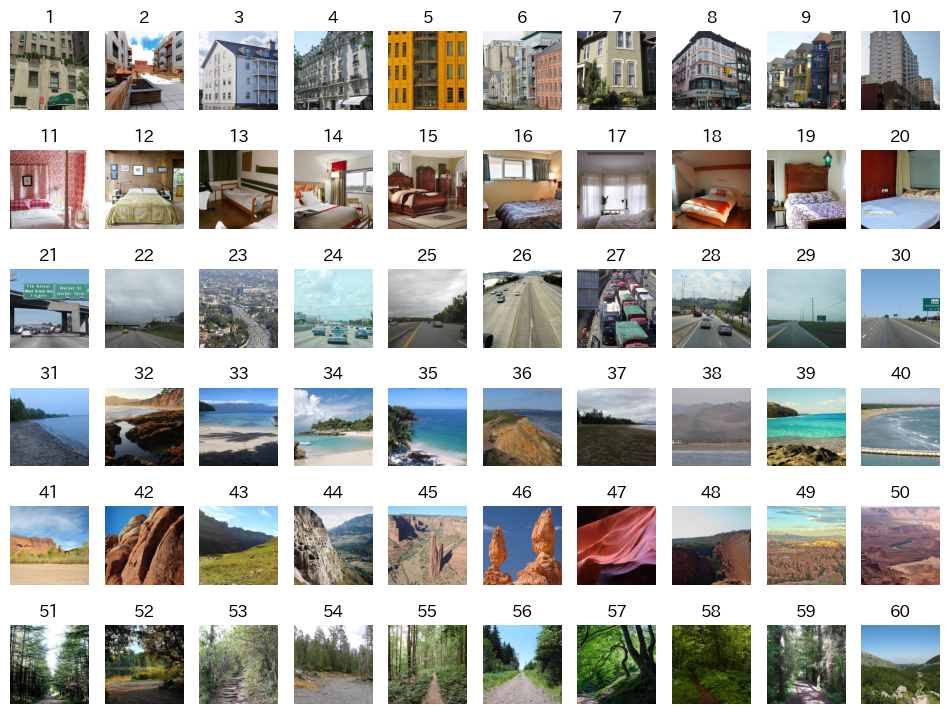

In [2]:
# 刺激画像の表示
nrows, ncols = 6, 10
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,9))
#fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14,10))

i=0
for row in range(nrows):
    for col in range(ncols):
        #img = PIL.Image.open(os.path.join(basedir, 'Stimuli/'+str(i+1)+'.jpg')).convert('RGB')
        img = PIL.Image.open(os.path.join(basedir, str(i+1)+'.jpg')).convert('RGB')
        ax[row][col].imshow(img)
        ax[row][col].axis('off')
        ax[row][col].set_title(f'{i+1}')
        i += 1

# 1-10: アパート
#11-20: ベッド
#21-30: 高速道路
#31-40: 海岸
#41-50: 峡谷
#51-60: 森林
# 1-30 は，人工物情景であり，31-60 は，自然情景

# 課題とバッチサイズの設定

In [3]:
task = 'desc'  # 識別課題
task = 'cat'   # カテゴリー弁別課題

# 'cat': カテゴリー化課題 (人工物か自然物か)，
# 'desc': 判別課題 (1-10:アパート，11-20:ベッド，21-30:高速道路, 31-40:海岸, 41-50:峡谷, 51-60:森林

batch_size = 12

# データセットの作成

In [4]:
# データセットの作成
import torchvision
from torchvision import transforms
import random

# 乱数シード固定（再現性の担保）
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
fix_seed(seed)

# データローダーのサブプロセスの乱数の seed 固定
def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)

for i in range(8):
    worker_init_fn(i)

class Agressa2023_dataset(torch.utils.data.Dataset):
    def __init__(self,
                 task:str='cat',
# 'cat': カテゴリー化課題 (人工物か自然物か)，
# 'desc': 判別課題 (1-10:アパート，11-20:ベッド，21-30:高速道路, 31-40:海岸, 41-50:峡谷, 51-60:森林
                 ):
        super().__init__()
        if task == 'desc':
            self.task = 'desc'
        else:
            self.task = 'cat'

        if isColab:
            self.basedir = '/content/drive/Shareddrives/#2024認知心理学研究(1)b/浅川先生/2023Karapetian+OSF/Stimuli'
            self.fnames = list(sorted(glob.glob(os.path.join(basedir,'*.jpg'))))
        else:
            HOME = os.environ['HOME']
            self.basedir = os.path.join(HOME, 'study/2024Agnessa14_Perceptual-decision-making.git/Stimuli')
            self.fnames = list(sorted(glob.glob(os.path.join(basedir,'*.jpg'))))
        self.fname = fnames

        self.Img_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(224),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

    def __len__(self):
        return len(self.fname)

    def __getitem__(self, idx):
        img_fname = self.fname[idx]
        #img = PIL.Image.open(os.path.join(basedir, 'Stimuli/'+str(idx+1)+'.jpg')).convert('RGB')
        img = PIL.Image.open(os.path.join(self.basedir, str(idx+1)+'.jpg')).convert('RGB')
        #X = torchvision.transforms.functional.pil_to_tensor(img)
        X = self.Img_transform(img)

        if self.task == 'cat':
            # カテゴリ弁別課題であれば，idx < 30 なら 0 (人工物), idx >= 30 なら 1 (自然物) という二値弁別課題
            label = idx // 30
        else:
            # 識別課題であれば，idx < 10:アパート，10<=idx<20:ベッド，20<=idx<30:高速道路
            #              30<=idx<40:海岸,   40<=idx<50:峡谷, 50<=idx<60:森林
            label = idx // 10

        return X, label

ds = Agressa2023_dataset(task=task)
train_dl = torch.utils.data.DataLoader(ds,
                                       batch_size=batch_size,    # バッチサイズ
                                       shuffle=True,     # データシャッフル
                                       num_workers=0,    # 高速化
                                       pin_memory=True,  # 高速化
                                       worker_init_fn=worker_init_fn
                                      )

# モデルの定義

## `torch.nn.Conv2d` の引数

* in_channels: int, 入力特徴数，(チャンネル数)
* out_channels: int, 出力特徴数 (チャンネル数)
* kernel_size: Union[int, Tuple[int, int]], カーネルサイズ，数字を 1 つだけ与えると 縦横とも同じサイズのカーネル幅になる
* stride: Union[int, Tuple[int, int]] = 1,  ストライド，カーネルをスライドさせる幅，数字を 1 だけ与えると縦横とも同サイズの幅となる
* padding: Union[str, int, Tuple[int, int]] = 0, 4 角に加える幅，数字を 1 つだけ与えると上下左右とも同サイズの幅にまる。
W x H の画像に対して，横幅は，W_pad + W + W_pad となり，縦長は H_pad + H + H_pad となるので，H x W の入力データが (W + 2 W_pad) * (H + 2 H_pad) のサイズとなる
* dilation: Union[int, Tuple[int, int]] = 1
ダイレーションの幅，畳み込みカーネルの間隙を指定する
* groups: int = 1,
* bias: bool = True,
バイアス項 `X @ w + b` にするときの `b` のこと
* padding_mode: str = 'zeros', device=None, dtype=None) -> None        
`padding` で指定した 4 角の拡張領域をどのような数値で埋めるかを指定する。デフォルトでは `zeros` すなわち 0 パディングとなる。
そのほかに取りうる値は，`reflect`, `replicate`, `circular` である。

$$
H_{\text{out}} = \frac{H_{in} + 2 H_{\text{pad}} - H_{\text{dilation}}\times \left(H_{\text{kernel}} -1\right)+1}{H_{\text{stride}}}
$$

$$
W_{\text{out}} = \frac{W_{in} + 2 W_{\text{pad}} - W_{\text{dilation}}\times \left(W_{\text{kernel}} -1\right)+1}{W_{\text{stride}}}
$$

## `torch.nn.MacPool2d` の引数

* kernel_size: Union[int, Tuple[int, ...]],
* stride: Union[int, Tuple[int, ...], NoneType] = None,
* padding: Union[int, Tuple[int, ...]] = 0,
* dilation: Union[int, Tuple[int, ...]] = 1,
* return_indices: bool = False,
* ceil_mode: bool = False) -> None

$$
out(N_i,C_j,h,w)= \max_{m=0, \ldots, kH-1} \max_{n=0, \ldots, kW-1}
\text{input}\left(N_i, C_j, \text{stride[0]} \times h + m, \text{stride[1]} \times w + n\right)
$$



In [5]:
import torch.nn as nn
# import torch.nn.functional as F

def conv3x3(
    in_features:int,
    out_features:int,
    stride:int=1,
    groups:int=1,
    dilation:int=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_channels=in_features,
        out_channels=out_features,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation)


def conv1x1(
    in_features:int,
    out_features:int,
    stride:int=1):
    """1x1 convolution"""
    return nn.Conv2d(
        in_channels=in_features,
        out_channels=out_features,
        kernel_size=1,
        stride=stride,
        bias=False)


class ResNet_BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(self,
                 in_features:int,
                 out_features:int,
                 stride:int=1,
                 downsample:bool=None,
                 groups:int=1,
                 base_width:int=64,
                 dilation:int=1,
                 norm_layer:bool=None):

        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self.conv1 = conv3x3(
            in_features=in_features,
            out_features=out_features,
            stride=stride)
        self.bn1 = norm_layer(out_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_features, out_features)
        self.bn2 = norm_layer(out_features)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [6]:
class ResNet_Bottleneck(nn.Module):
    # ボトルネックは、ダウンサンプリングのストライドを 3x3 convolution(self.conv2) に置くのに対し、
    # オリジナルの実装では最初の 1x1 convolution(self.conv1) にしています。
    # [Deep residual learning for image recognition](https://arxiv.org/abs/1512.03385) によると、
    # ダウンサンプリングのストライドを 3x3 convolution(self.conv2) にしています。
    # このバージョンは ResNet V1.5 としても知られており、精度が向上しています。
    # (https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch)

    #expansion: int = 4

    def __init__(self, in_features, out_features,
                 stride=1,
                 downsample=None,
                 groups=1,
                 base_width=64,
                 dilation=1,
                 norm_layer= None):

        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(out_featuress * (base_width / 64.0)) * groups

        self.expansion = 4

        self.conv1 = conv1x1(in_features, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, otu_features * self.expansion)
        self.bn3 = norm_layer(out_features * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, inp):
        identity = inp

        out = self.conv1(inp)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self,
                 block,
                 layers,
                 in_channels = 3,
                 num_classes = 40, # 1000,
                 zero_init_residual=False,
                 groups=1,
                 width_per_group=64,
                 #width_per_group=8,
                 norm_layer=None):

        super().__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.in_features = 64
        self.dilation = 1
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(in_channels, self.in_features, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.in_features)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # 各残差ブランチの最後のバッチ正規化をゼロ初期化し，残差ブランチがゼロで始まり，各残差ブロックが恒等写像のように振る舞うようにします。
        # https://arxiv.org/abs/1706.02677 によると，これによりモデルが 0.2~0.3 %改善されます。
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self,
                    block,
                    out_features,
                    blocks,
                    stride=1):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if stride != 1 or self.in_features != out_features * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.in_features, out_features * block.expansion, stride),
                norm_layer(out_features * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.in_features, out_features, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.in_features = out_features * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.in_features,
                    out_features,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, **kwargs):
    model = ResNet(block, layers, **kwargs)
    return model


def resnet18(**kwargs):
    """ResNet-18 model from [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)
    """
    return _resnet("resnet18", ResNet_BasicBlock, [1, 1, 1, 1], **kwargs)
    #return _resnet("resnet18", ResNet_BasicBlock, [2, 2, 2, 2], **kwargs)


In [ ]:
#from torchsummary import summary

in_channels=3
a_model = resnet18(in_channels=in_channels, num_classes=6).to(device)
#print(tmp_resnet_model)
#summary(model, input_size=(in_channels,64,64))
a_model.eval()

In [12]:
lr = 0.01
#lr = 0.1
#lr = 0.001
# 最適化手法の設定
# #optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(params=a_model.parameters(), lr=lr)
#type(optimizer)

criterion = torch.nn.CrossEntropyLoss()
#criterion = torch.nn.MSELoss()

verbose = False
n_epochs = 20
a_model.train()
for epoch in range(n_epochs):
    epoch_loss = 0.
    n_corrects = 0
    for X, y in train_dl:
        optimizer.zero_grad()
        out = a_model(X.to(device))
        if verbose:
            print(f'エポック:{epoch+1}',
                  f'教師:{y.detach().numpy()}',
                  f'出力:{out.argmax(dim=1).numpy()}',
                  f'正誤:{(y.numpy() == out.argmax(dim=1).numpy()) * 1}'
                 )
        loss = criterion(out.cpu(), y.cpu())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        n_corrects += np.sum((y.cpu().numpy() == out.cpu().argmax(dim=1).numpy()) * 1)

    print(f'エポック:{epoch+1:03d}',
          f'損失:{epoch_loss:.3f}',
          f'正解率:{n_corrects}/{ds.__len__()}'
         )

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


エポック:001 損失:8.138 正解率:28/60
エポック:002 損失:3.857 正解率:33/60
エポック:003 損失:3.537 正解率:38/60
エポック:004 損失:2.925 正解率:36/60
エポック:005 損失:2.552 正解率:44/60
エポック:006 損失:3.201 正解率:38/60
エポック:007 損失:3.233 正解率:39/60
エポック:008 損失:2.897 正解率:41/60
エポック:009 損失:3.382 正解率:45/60
エポック:010 損失:2.313 正解率:44/60
エポック:011 損失:2.095 正解率:49/60
エポック:012 損失:2.249 正解率:48/60
エポック:013 損失:2.333 正解率:46/60
エポック:014 損失:1.974 正解率:52/60
エポック:015 損失:2.109 正解率:47/60
エポック:016 損失:1.924 正解率:48/60
エポック:017 損失:1.841 正解率:51/60
エポック:018 損失:2.086 正解率:47/60
エポック:019 損失:0.842 正解率:59/60
エポック:020 損失:1.004 正解率:56/60


# 学習済モデルを用いる

In [13]:
from torchvision import models

# ここでは，AlexNet か ResNet18, ResNet50 を仮定している
#a_model = models.alexnet(weights='DEFAULT', progress=True)
#a_model = models.alexnet(weights=None, progress=True)
#a_model_name = 'AlexNet'

#a_model = models.resnet50(weights='DEFAULT', progress=True)
#a_model = models.resnet50(weights=None, progress=True)
#a_model_name = 'ResNet50'

a_model = models.resnet18(weights='DEFAULT', progress=True)
a_model = models.resnet18(weights=None, progress=True)
a_model_name = 'ResNet18'

print(a_model.eval())
print(f'a_model_name:{a_model_name}')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
a_parameters = {name:param for name, param in a_model.named_parameters()}
a_modules = {name:param for name, param in a_model.named_modules()}

print(f'パラメータ名:{a_parameters.keys()}')
print(f'モジュール名:{a_modules.keys()}')

パラメータ名:dict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', 'layer2.0.downsample.0.weight', 'layer2.0.downsample.1.weight', 'layer2.0.downsample.1.bias', 'layer2.1.conv1.weight', 'layer2.1.bn1.weight', 'layer2.1.bn1.bias', 'layer2.1.conv2.weight', 'layer2.1.bn2.weight', 'layer2.1.bn2.bias', 'layer3.0.conv1.weight', 'layer3.0.bn1.weight', 'layer3.0.bn1.bias', 'layer3.0.conv2.weight', 'layer3.0.bn2.weight', 'layer3.0.bn2.bias', 'layer3.0.downsample.0.weight', 'layer3.0.downsample.1.weight', 'layer3.0.downsample.1.bias', 'layer3.1.conv1.weight', 'layer3.1.bn1.weight', 'layer3.1.bn1.

In [15]:
# 解くべき課題に応じて，最終層の素子数を変更する
if task == 'desc':  # 弁別課題の場合
    out_features = 6
elif task == 'cat': # カテゴリー弁別課題の場合
    out_features = 2

if a_model_name == 'AlexNet':
    in_features = a_model.classifier[6].in_features
    a_model.classifier[6] = torch.nn.Linear(in_features=in_features, out_features=out_features)
elif a_model_name == 'ResNet50':
    in_features = a_model.fc.in_features
    a_model.fc = torch.nn.Linear(in_features=in_features, out_features=out_features)
elif a_model_name == 'ResNet18':
    in_features = a_model.fc.in_features
    a_model.fc = torch.nn.Linear(in_features=in_features, out_features=out_features)

print(f'in_features:{in_features}',
      f'out_feaures:{out_features}'
     )
a_model.eval()

in_features:512 out_feaures:2


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
if a_model_name == 'AlexNet':
    update_param_names = ['classifier.6.weight', 'classifier.6.bias']
elif 'ResNet' in a_model_name:
    update_param_names = ['fc.weight', 'fc.bias']
params_to_update = []
for name, param in a_model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False
#print(f'parmas_to_update:{params_to_update}')


fc.weight
fc.bias


In [ ]:
lr = 0.01
lr = 0.001
# 最適化手法の設定
# #optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(params=params_to_update, lr=lr)
#type(optimizer)

criterion = torch.nn.CrossEntropyLoss()
#criterion = torch.nn.MSELoss()

verbose = False
n_epochs = 20
a_model.train()
for epoch in range(n_epochs):
    epoch_loss = 0.
    n_corrects = 0
    for X, y in train_dl:
        optimizer.zero_grad()
        out = a_model(X)
        if verbose:
            print(f'エポック:{epoch+1}',
                  f'教師:{y.detach().numpy()}',
                  f'出力:{out.argmax(dim=1).numpy()}',
                  f'正誤:{(y.numpy() == out.argmax(dim=1).numpy()) * 1}'
                 )
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        n_corrects += np.sum((y.numpy() == out.argmax(dim=1).numpy()) * 1)

    print(f'エポック:{epoch+1:03d}',
          f'損失:{epoch_loss:.3f}',
          f'正解率:{n_corrects}/{ds.__len__()}'
         )

エポック:001 損失:3.517 正解率:33/60
エポック:002 損失:3.555 正解率:32/60
エポック:003 損失:3.480 正解率:31/60
エポック:004 損失:3.445 正解率:33/60
エポック:005 損失:3.421 正解率:32/60
エポック:006 損失:3.249 正解率:36/60
エポック:007 損失:3.329 正解率:38/60
エポック:008 損失:3.261 正解率:35/60
エポック:009 損失:3.253 正解率:39/60
エポック:010 損失:3.152 正解率:40/60
エポック:011 損失:3.154 正解率:40/60
エポック:012 損失:3.132 正解率:41/60
エポック:013 損失:3.071 正解率:43/60
エポック:014 損失:3.112 正解率:39/60
エポック:015 損失:3.104 正解率:41/60
エポック:016 損失:3.058 正解率:45/60
エポック:017 損失:3.007 正解率:44/60
エポック:018 損失:2.973 正解率:44/60
エポック:019 損失:3.124 正解率:42/60
エポック:020 損失:3.390 正解率:34/60


In [ ]:
# ここでは，AlexNet か ResNet18, ResNet50 を仮定している
a_model = models.alexnet(weights='DEFAULT', progress=True).to(device)
#a_model = models.alexnet(weights=None, progress=True).to(device)
a_model_name = 'AlexNet'
a_model.eval()


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
lr = 0.01
optimizer = torch.optim.Adam(params=a_model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

a_model.train()
n_epochs = 50
verbose = False
for epoch in range(n_epochs):
    epoch_loss = 0.
    n_corrects = 0
    for X, y in train_dl:
        optimizer.zero_grad()
        out = a_model(X.to(device))
        if verbose:
            print(f'エポック:{epoch+1}',
                  f'教師:{y.detach().numpy()}',
                  f'出力:{out.cpu().argmax(dim=1).numpy()}',
                  f'正誤:{(y.numpy() == out.cpu().argmax(dim=1).numpy()) * 1}'
                 )
        loss = criterion(out.cpu(), y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        n_corrects += np.sum((y.numpy() == out.cpu().argmax(dim=1).numpy()) * 1)

    print(f'エポック:{epoch+1:03d}',
          f'損失:{epoch_loss:.3f}',
          f'正解率:{n_corrects}/{ds.__len__()}'
         )

エポック:001 損失:44888.824 正解率:25/60
エポック:002 損失:3364.018 正解率:28/60
エポック:003 損失:13086.251 正解率:33/60
エポック:004 損失:2306.320 正解率:26/60
エポック:005 損失:3910.673 正解率:35/60
エポック:006 損失:2595.829 正解率:27/60
エポック:007 損失:185.958 正解率:38/60
エポック:008 損失:86.598 正解率:33/60
エポック:009 損失:78.712 正解率:37/60
エポック:010 損失:14.294 正解率:25/60
エポック:011 損失:3.539 正解率:31/60
エポック:012 損失:26.966 正解率:29/60
エポック:013 損失:3.658 正解率:27/60
エポック:014 損失:3.565 正解率:31/60
エポック:015 損失:4.012 正解率:27/60
エポック:016 損失:3.508 正解率:32/60
エポック:017 損失:3.646 正解率:27/60
エポック:018 損失:3.555 正解率:30/60
エポック:019 損失:3.551 正解率:28/60
エポック:020 損失:3.743 正解率:26/60
エポック:021 損失:3.551 正解率:30/60
エポック:022 損失:3.533 正解率:28/60
エポック:023 損失:3.643 正解率:29/60
エポック:024 損失:3.482 正解率:29/60
エポック:025 損失:3.488 正解率:31/60
エポック:026 損失:3.578 正解率:31/60
エポック:027 損失:3.518 正解率:27/60
エポック:028 損失:3.490 正解率:34/60
エポック:029 損失:3.399 正解率:36/60
エポック:030 損失:3.517 正解率:33/60
エポック:031 損失:3.542 正解率:31/60
エポック:032 損失:3.582 正解率:29/60
エポック:033 損失:3.582 正解率:28/60
エポック:034 損失:3.504 正解率:36/60
エポック:035 損失:3.750 正解率: